In [1]:
import json
import pandas as pd
import random
from sklearn.metrics import accuracy_score
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from gensim.models import KeyedVectors
import numpy as np
from scipy.spatial.distance import cosine
import fasttext
import gensim.downloader
import matplotlib.pyplot as plt


In [2]:
with open('train_rand_split.jsonl', 'r') as file:
    data = [json.loads(line) for line in file]

In [3]:
data

[{'answerKey': 'A',
  'id': '075e483d21c29a511267ef62bedc0461',
  'question': {'question_concept': 'punishing',
   'choices': [{'label': 'A', 'text': 'ignore'},
    {'label': 'B', 'text': 'enforce'},
    {'label': 'C', 'text': 'authoritarian'},
    {'label': 'D', 'text': 'yell at'},
    {'label': 'E', 'text': 'avoid'}],
   'stem': 'The sanctions against the school were a punishing blow, and they seemed to what the efforts the school had made to change?'}},
 {'answerKey': 'B',
  'id': '61fe6e879ff18686d7552425a36344c8',
  'question': {'question_concept': 'people',
   'choices': [{'label': 'A', 'text': 'race track'},
    {'label': 'B', 'text': 'populated areas'},
    {'label': 'C', 'text': 'the desert'},
    {'label': 'D', 'text': 'apartment'},
    {'label': 'E', 'text': 'roadblock'}],
   'stem': 'Sammy wanted to go to where the people were.  Where might he go?'}},
 {'answerKey': 'A',
  'id': '4c1cb0e95b99f72d55c068ba0255c54d',
  'question': {'question_concept': 'choker',
   'choices': [

In [4]:
df = pd.DataFrame(data)

In [5]:
df

,answerKey,id,question
0,A,075e483d21c29a511267ef62bedc0461,"{'question_concept': 'punishing', 'choices': [..."
1,B,61fe6e879ff18686d7552425a36344c8,"{'question_concept': 'people', 'choices': [{'l..."
2,A,4c1cb0e95b99f72d55c068ba0255c54d,"{'question_concept': 'choker', 'choices': [{'l..."
3,D,02e821a3e53cb320790950aab4489e85,"{'question_concept': 'highway', 'choices': [{'..."
4,C,23505889b94e880c3e89cff4ba119860,"{'question_concept': 'fox', 'choices': [{'labe..."
...,...,...,...
9736,E,f1b2a30a1facff543e055231c5f90dd0,"{'question_concept': 'going public', 'choices'..."
9737,D,a63b4d0c0b34d6e5f5ce7b2c2c08b825,"{'question_concept': 'chair', 'choices': [{'la..."
9738,A,22d0eea15e10be56024fd00bb0e4f72f,"{'question_concept': 'jeans', 'choices': [{'la..."
9739,A,7c55160a4630de9690eb328b57a18dc2,"{'question_concept': 'well', 'choices': [{'lab..."


In [6]:
df["question"][0]

{'question_concept': 'punishing',
 'choices': [{'label': 'A', 'text': 'ignore'},
  {'label': 'B', 'text': 'enforce'},
  {'label': 'C', 'text': 'authoritarian'},
  {'label': 'D', 'text': 'yell at'},
  {'label': 'E', 'text': 'avoid'}],
 'stem': 'The sanctions against the school were a punishing blow, and they seemed to what the efforts the school had made to change?'}

In [7]:
# Extract relevant features from the question dictionary
df['stem'] = df['question'].apply(lambda x: x['stem'])
df['choices'] = df['question'].apply(lambda x: {choice['label']: choice['text'] for choice in x['choices']})

df.drop('question', axis=1, inplace=True)

df = df[['id', 'stem', 'choices', 'answerKey']]



In [8]:
df

,id,stem,choices,answerKey
0,075e483d21c29a511267ef62bedc0461,The sanctions against the school were a punish...,"{'A': 'ignore', 'B': 'enforce', 'C': 'authorit...",A
1,61fe6e879ff18686d7552425a36344c8,Sammy wanted to go to where the people were. ...,"{'A': 'race track', 'B': 'populated areas', 'C...",B
2,4c1cb0e95b99f72d55c068ba0255c54d,To locate a choker not located in a jewelry bo...,"{'A': 'jewelry store', 'B': 'neck', 'C': 'jewl...",A
3,02e821a3e53cb320790950aab4489e85,Google Maps and other highway and street GPS s...,"{'A': 'united states', 'B': 'mexico', 'C': 'co...",D
4,23505889b94e880c3e89cff4ba119860,"The fox walked from the city into the forest, ...","{'A': 'pretty flowers.', 'B': 'hen house', 'C'...",C
...,...,...,...,...
9736,f1b2a30a1facff543e055231c5f90dd0,What would someone need to do if he or she wan...,"{'A': 'consequences', 'B': 'being ridiculed', ...",E
9737,a63b4d0c0b34d6e5f5ce7b2c2c08b825,Where might you find a chair at an office?,"{'A': 'stadium', 'B': 'kitchen', 'C': 'porch',...",D
9738,22d0eea15e10be56024fd00bb0e4f72f,Where would you buy jeans in a place with a la...,"{'A': 'shopping mall', 'B': 'laundromat', 'C':...",A
9739,7c55160a4630de9690eb328b57a18dc2,John fell down the well. he couldn't believe ...,"{'A': 'fairytale', 'B': 'farm yard', 'C': 'far...",A


In [9]:
df.isna().sum()

id           0
stem         0
choices      0
answerKey    0
dtype: int64

In [10]:
df["answerKey"].unique()

array(['A', 'B', 'D', 'C', 'E'], dtype=object)

# Use Baseline Model => just Random Guessing

In [102]:
answer_choices = df["choices"]

random_predictions = [random.choice(list(choices.keys())) for choices in answer_choices]

In [103]:
random_predictions

['E',
 'E',
 'E',
 'E',
 'D',
 'C',
 'D',
 'D',
 'A',
 'C',
 'A',
 'D',
 'B',
 'D',
 'E',
 'A',
 'A',
 'B',
 'D',
 'A',
 'B',
 'C',
 'A',
 'B',
 'C',
 'C',
 'B',
 'D',
 'E',
 'A',
 'B',
 'B',
 'E',
 'E',
 'E',
 'A',
 'D',
 'C',
 'C',
 'A',
 'C',
 'C',
 'D',
 'D',
 'B',
 'B',
 'E',
 'A',
 'E',
 'B',
 'B',
 'D',
 'C',
 'E',
 'B',
 'A',
 'D',
 'B',
 'B',
 'A',
 'B',
 'C',
 'D',
 'C',
 'D',
 'B',
 'C',
 'B',
 'E',
 'A',
 'A',
 'C',
 'C',
 'B',
 'D',
 'E',
 'B',
 'C',
 'B',
 'B',
 'D',
 'C',
 'A',
 'B',
 'D',
 'C',
 'B',
 'C',
 'D',
 'D',
 'D',
 'E',
 'D',
 'D',
 'D',
 'D',
 'E',
 'A',
 'C',
 'D',
 'B',
 'A',
 'D',
 'C',
 'B',
 'A',
 'B',
 'A',
 'D',
 'B',
 'B',
 'E',
 'D',
 'D',
 'C',
 'B',
 'B',
 'A',
 'A',
 'C',
 'A',
 'E',
 'D',
 'C',
 'A',
 'C',
 'E',
 'D',
 'D',
 'E',
 'A',
 'D',
 'A',
 'A',
 'C',
 'E',
 'A',
 'A',
 'A',
 'D',
 'B',
 'A',
 'A',
 'C',
 'A',
 'D',
 'E',
 'B',
 'D',
 'C',
 'C',
 'A',
 'A',
 'E',
 'B',
 'B',
 'C',
 'E',
 'D',
 'D',
 'C',
 'B',
 'A',
 'C',
 'E',
 'E',
 'D'

# Compute the accuracy for this model  

In [104]:
correct_answers = df["answerKey"]
accuracy_of_the_baseline_model = accuracy_score(correct_answers, random_predictions)
print("Random Guessing Baseline Accuracy:", accuracy_of_the_baseline_model)

Random Guessing Baseline Accuracy: 0.20080073914382507


# Preprocessing-Phase 

In [14]:
df['tokens'] = df['stem'].apply(word_tokenize)

C:\Users\IMOE001\AppData\Local\Temp\ipykernel_10804\668070078.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tokens'] = df['stem'].apply(word_tokenize)


In [15]:
df["stem"] = df['tokens']

C:\Users\IMOE001\AppData\Local\Temp\ipykernel_10804\959468976.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["stem"] = df['tokens']


In [16]:
df = df.drop(columns=['tokens'])

In [17]:
# Convert all words to lowercase 
#df["stem"] = df["stem"].apply(lambda x: [word.lower() for word in x])

In [18]:
df["stem"]

0       [The, sanctions, against, the, school, were, a...
1       [Sammy, wanted, to, go, to, where, the, people...
2       [To, locate, a, choker, not, located, in, a, j...
3       [Google, Maps, and, other, highway, and, stree...
4       [The, fox, walked, from, the, city, into, the,...
                              ...                        
9736    [What, would, someone, need, to, do, if, he, o...
9737    [Where, might, you, find, a, chair, at, an, of...
9738    [Where, would, you, buy, jeans, in, a, place, ...
9739    [John, fell, down, the, well, ., he, could, n'...
9740    [I, forgot, to, pay, the, electricity, bill, ,...
Name: stem, Length: 9741, dtype: object

# Remove Stop Words

In [19]:
stop_words = set(stopwords.words('english'))

In [20]:
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [21]:
# Remove stop words from the tokens
df["stem"] = df["stem"].apply(lambda x: [word for word in x if word not in stop_words])

In [22]:
# Remove punctuation from the tokens
df["stem"] = df["stem"].apply(lambda x: [word for word in x if word not in string.punctuation])

In [23]:
df["stem"][0]

['The',
 'sanctions',
 'school',
 'punishing',
 'blow',
 'seemed',
 'efforts',
 'school',
 'made',
 'change']

In [24]:
def tokenize_answers(choices):
    tokenized_choices = {}
    for key, value in choices.items(): #as a tuple 
        tokens = word_tokenize(value)  # Tokenize the answer choice
        tokenized_choices[key] = tokens
    return tokenized_choices

In [25]:
df["choices"] = df["choices"].apply(tokenize_answers)

In [26]:
df["choices"] 

0       {'A': ['ignore'], 'B': ['enforce'], 'C': ['aut...
1       {'A': ['race', 'track'], 'B': ['populated', 'a...
2       {'A': ['jewelry', 'store'], 'B': ['neck'], 'C'...
3       {'A': ['united', 'states'], 'B': ['mexico'], '...
4       {'A': ['pretty', 'flowers', '.'], 'B': ['hen',...
                              ...                        
9736    {'A': ['consequences'], 'B': ['being', 'ridicu...
9737    {'A': ['stadium'], 'B': ['kitchen'], 'C': ['po...
9738    {'A': ['shopping', 'mall'], 'B': ['laundromat'...
9739    {'A': ['fairytale'], 'B': ['farm', 'yard'], 'C...
9740    {'A': ['put', 'in', 'to', 'the', 'water'], 'B'...
Name: choices, Length: 9741, dtype: object

# Load  The Models

In [27]:
word2vec_model_path = 'C:\\Users\\IMOE001\\Desktop\\GoogleNews-vectors-negative300.bin'
fasttext_model_path = 'C:\\Users\\IMOE001\\Desktop\\wiki-news-300d-1M.vec'

In [28]:
glove_model = gensim.downloader.load('glove-wiki-gigaword-300')
word2vec_model = KeyedVectors.load_word2vec_format(word2vec_model_path, binary=True)
fasttext_model = KeyedVectors.load_word2vec_format(fasttext_model_path)

In [44]:
# Test some words
words_to_test = ['king','King']

# Check if each word is present in the vocabulary
for word in words_to_test:
    if word in word2vec_model:
        print(f"Vector representation of '{word}': {word2vec_model[word]}")
    else:
        print(f"'{word}' is not present in the vocabulary.")


Vector representation of 'king': [ 1.25976562e-01  2.97851562e-02  8.60595703e-03  1.39648438e-01
 -2.56347656e-02 -3.61328125e-02  1.11816406e-01 -1.98242188e-01
  5.12695312e-02  3.63281250e-01 -2.42187500e-01 -3.02734375e-01
 -1.77734375e-01 -2.49023438e-02 -1.67968750e-01 -1.69921875e-01
  3.46679688e-02  5.21850586e-03  4.63867188e-02  1.28906250e-01
  1.36718750e-01  1.12792969e-01  5.95703125e-02  1.36718750e-01
  1.01074219e-01 -1.76757812e-01 -2.51953125e-01  5.98144531e-02
  3.41796875e-01 -3.11279297e-02  1.04492188e-01  6.17675781e-02
  1.24511719e-01  4.00390625e-01 -3.22265625e-01  8.39843750e-02
  3.90625000e-02  5.85937500e-03  7.03125000e-02  1.72851562e-01
  1.38671875e-01 -2.31445312e-01  2.83203125e-01  1.42578125e-01
  3.41796875e-01 -2.39257812e-02 -1.09863281e-01  3.32031250e-02
 -5.46875000e-02  1.53198242e-02 -1.62109375e-01  1.58203125e-01
 -2.59765625e-01  2.01416016e-02 -1.63085938e-01  1.35803223e-03
 -1.44531250e-01 -5.68847656e-02  4.29687500e-02 -2.46582

In [45]:
def number_of_words_without_embedding(the_column,the_column2 ,  model):
    count = 0
    for wordlist in the_column:
        for word in wordlist:
            if word not in model:
                count += 1
                
    for row in the_column2 : 
        for wordlist in row.values() : 
            for word in wordlist:
                if word not in model:
                    count += 1
    return count

In [46]:
number_of_words_without_embedding_using_word2vec = number_of_words_without_embedding(df["stem"] , df["choices"] ,  word2vec_model )
number_of_words_w1ithout_embedding_using_fasttext = number_of_words_without_embedding(df["stem"] ,df["choices"], fasttext_model )
number_of_words_w1ithout_embedding_using_Glove = number_of_words_without_embedding(df["stem"] , df["choices"] , glove_model )

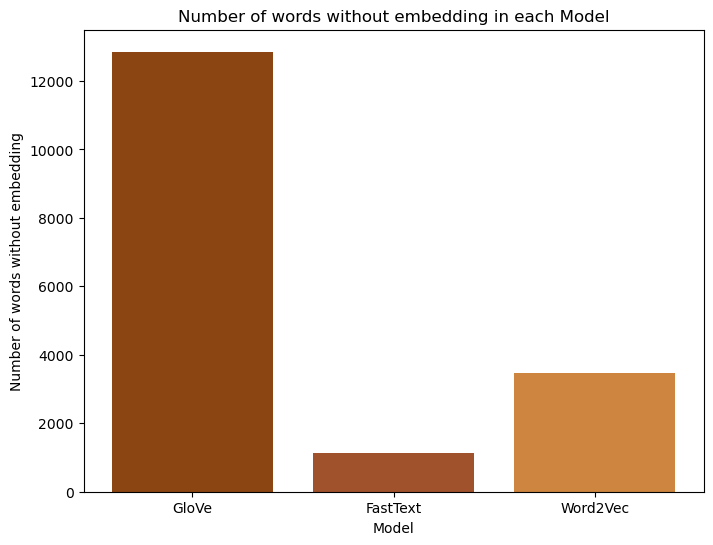

In [47]:
no_of_words_without_embedding_in_each_model = [number_of_words_w1ithout_embedding_using_Glove , number_of_words_w1ithout_embedding_using_fasttext , number_of_words_without_embedding_using_word2vec]
model_names_2 = ['GloVe', 'FastText', 'Word2Vec']
plt.figure(figsize=(8, 6))

plt.bar(model_names_2, no_of_words_without_embedding_in_each_model , color = ['#8B4513', '#A0522D', '#CD853F', '#D2691E'])

plt.xlabel('Model')
plt.ylabel('Number of words without embedding')
plt.title('Number of words without embedding in each Model')

plt.show()


In [48]:
def convert_question_to_vector(words, model):
    word_vectors = [] 
    for word in words:
        if word in model:
            word_vectors.append(model[word])
    if word_vectors:
        return  np.mean(word_vectors, axis=0)
    else:
        return  np.zeros(model.vector_size)    # Return zero vector if no words found in the model

In [49]:
df["question_vectors_word2vec"] = df["stem"].apply(lambda x: convert_question_to_vector(x, word2vec_model))
df["question_vectors_fasttext"] = df["stem"].apply(lambda x: convert_question_to_vector(x, fasttext_model))
df["question_vectors_glove"] = df["stem"].apply(lambda x: convert_question_to_vector(x, glove_model))

In [50]:
def convert_answer_to_vector(choices, model):
    average_vectors = {}
    for key, tokens in choices.items():
        word_vectors = []
        for token in tokens:
            if token in model: 
                word_vectors.append(model[token])
        if word_vectors:
            average_vector = np.mean(word_vectors, axis=0)
        else:
            average_vector = np.zeros(model.vector_size)
        average_vectors[key] = average_vector
    return average_vectors

In [51]:
df["answer_vectors_word2vec"] = df["choices"].apply(lambda x: convert_answer_to_vector(x, word2vec_model))
df["answer_vectors_fastext"] = df["choices"].apply(lambda x: convert_answer_to_vector(x, fasttext_model))
df["answer_vectors_glove"] = df["choices"].apply(lambda x: convert_answer_to_vector(x, glove_model))

   # Making predictions using models 

In [52]:
def cosine_similarity(x, y):
    dot_product = np.dot(x, y)
    
    magnitude_x = np.sqrt(np.sum(x**2)) 
    magnitude_y = np.sqrt(np.sum(y**2))
    
    cosine_similarity = dot_product / (magnitude_x * magnitude_y)
    
    return cosine_similarity

In [53]:
#here we want the vector that give me the maxmum cosine similarity with question vector
def get_predicted_answer(question_vector, answer_vectors):
    max_similarity = -2
    max_label = None
    for label, answer_vector in answer_vectors.items():
        similarity = cosine_similarity(question_vector, answer_vector)
        if similarity > max_similarity:
            max_similarity = similarity
            max_label = label
    return max_label

In [54]:
predicted_answers_use_word2vec = df.apply(lambda row: get_predicted_answer(row["question_vectors_word2vec"], row["answer_vectors_word2vec"]), axis=1)
predicted_answers_use_fasttex = df.apply(lambda row: get_predicted_answer(row["question_vectors_fasttext"] , row["answer_vectors_fastext"]), axis=1)
predicted_answers_use_glove = df.apply(lambda row: get_predicted_answer(row["question_vectors_glove"], row["answer_vectors_glove"]), axis=1)

C:\Users\IMOE001\AppData\Local\Temp\ipykernel_10804\136162183.py:7: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity = dot_product / (magnitude_x * magnitude_y)


In [55]:
accuracy_of_word2vec = accuracy_score(df["answerKey"], predicted_answers_use_word2vec)
print("Accuracy of word2vec:", accuracy_of_word2vec)

Accuracy of word2vec: 0.29863463710091365


In [56]:
accuracy_of_fastext = accuracy_score(df["answerKey"], predicted_answers_use_fasttex)
print("Accuracy of fasttex:", accuracy_of_fastext)

Accuracy of fasttex: 0.2455600041063546


In [59]:
predicted_answers_use_glove.fillna('A', inplace=True)

In [60]:
accuracy_of_glove = accuracy_score(df["answerKey"], predicted_answers_use_glove )
print("Accuracy of glove:", accuracy_of_glove)

Accuracy of glove: 0.26280669335797147


# Plot the Results 

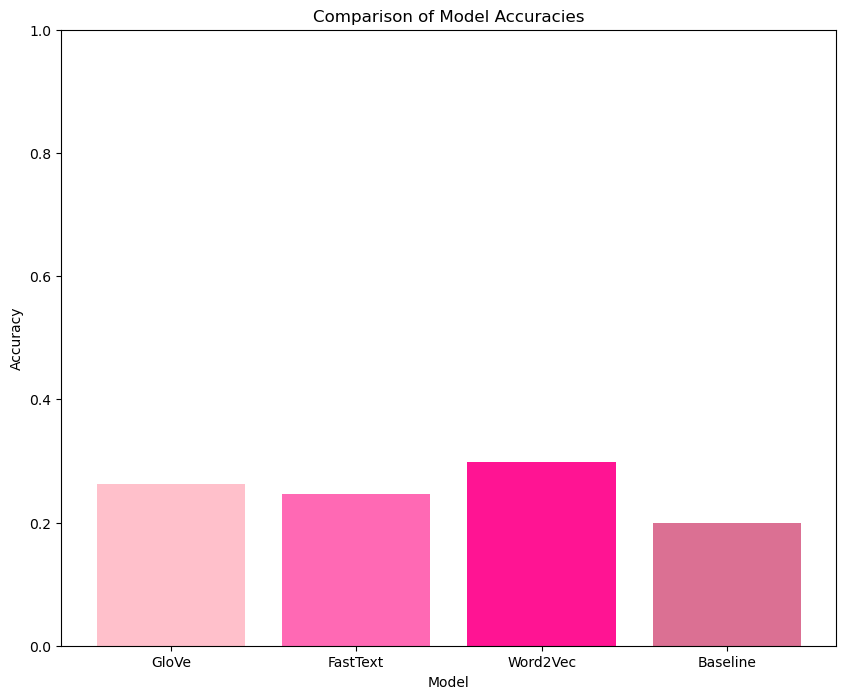

In [62]:
the_accuracy_score_for_models = [accuracy_of_glove , accuracy_of_fastext , accuracy_of_word2vec , accuracy_of_the_baseline_model ]

model_names = ['GloVe', 'FastText', 'Word2Vec', 'Baseline']

plt.figure(figsize=(10, 8))

plt.bar(model_names, the_accuracy_score_for_models, color = ['#FFC0CB', '#FF69B4', '#FF1493', '#DB7093'])

plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1 for accuracy score

plt.show()
